LTR Figure Generation for Peformance Evaluation:
------

This notebook is used to generate figures examining the LTR performance both for using different FED time intervals, and for comparing tracking metrics across several cases in reference to past studies (Lakshmanan and Smith, 2010).

The figures generated are in the following order:

    1) Geometry comparisons for different time intervals used to construct the FEDs. This contains comparisons between
    
            A) Track distance from OKLMA network center
            B) Tracked FOB area and eccentricities
            C) Tracked FOB smoothed orientations
            D) Storm tracks
            
    2) Orientation change evaluation to examine why FOB orientations may change for some cases as the linear system progresses through the analysis domain.
    
            A) OK-0621
            B) OK-1021
            
    3) Smoothed and Linear track fits for all cases used in study's evaluation section.
    4) LTR evaluation using evaluation metrics:
            A) Track duration
            B) Track linearity (RMSE of smooth v.s. linear fit track)
            C) Track "non-linearity" or RMSE of smooth v.s. polynomial (3rd order) fit
            D) Difference between linear and polynomial track fit (to exemplify the linear assumption of storm tracks is valid)
            E) Standard devaition of FOB area to show track consistency
            F) Centroid time-frame to time-frame differences to show tracking consistency if one large object is in analysis domain.
            
For comments or questions contact: vicente.salinas@noaa.gov

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import gaussian_filter1d as gf
import datetime
import Evaluate as ev

Read in Tracked Object Data
----
The following two cells are used to define the total flash counts per case.

In [2]:
#ref time frames for one minute increments for latter error analysis: 10-27-21
ref_for_time2  = pd.read_csv(f'Output/1min/TrackedData/211027/TRACKED-OBJECT-PROPS.csv')
ref_seconds2   = ref_for_time2.time.values
ref_seconds2e  = ref_for_time2.time.values + 60

ref_for_time  = pd.read_csv(f'Output/1min/TrackedData/210612/TRACKED-OBJECT-PROPS.csv')
ref_seconds   = ref_for_time.time.values
ref_secondse  = ref_for_time.time.values + 60

### Get flash rates

In [3]:
#Open pre-chunked data
flashes_c1 = xr.open_dataset('LightningData/LMA/sorted/2021-06-12-OKLMA_SAMPLED.nc')  
flashes_c2 = xr.open_dataset('LightningData/LMA/sorted/2021-10-27-OKLMA_SAMPLED.nc')    
#Get the flash rates per 1 minute using the pre-chunked data
in_time1 = ev.get_fcounts(flashes_c1,ref_seconds,ref_secondse)
in_time2 = ev.get_fcounts(flashes_c2,ref_seconds2,ref_seconds2e)

# Read in Tracked Ellipse and FOB Geometric Data:


In [4]:
#Compare geometric data across time resolutions and cases
#---------------------------------------------------------
#Set case
case = '20211027'
#List of possible time resolutions 
dts  = ['1min','5min','10min']
d1  ,c1 = ev.get_data(case,dts[0])
d5  ,c5 = ev.get_data(case,dts[1])
d10,c10 = ev.get_data(case,dts[2])

In [5]:
#Get tracked data variables to generate figures 4 and 6 of the manuscript
r1 ,t1 ,a1 ,e1  ,ag1 = ev.data_to_compare(c1)
r5 ,t5 ,a5 ,e5  ,ag5 = ev.data_to_compare(c5)
r10,t10,a10,e10,ag10 = ev.data_to_compare(c10)

## Plot time series of geometries:
The figure generated using these geometric data are:

    - Panel A) = time series of FOB distance from OKLMA network center
    - Panel B) = time series of FOB area and eccentricity (dashed)
    - Panel C) = time series of FOB orientation
    - Panel D) = FOB centroids for all time frame resolutions

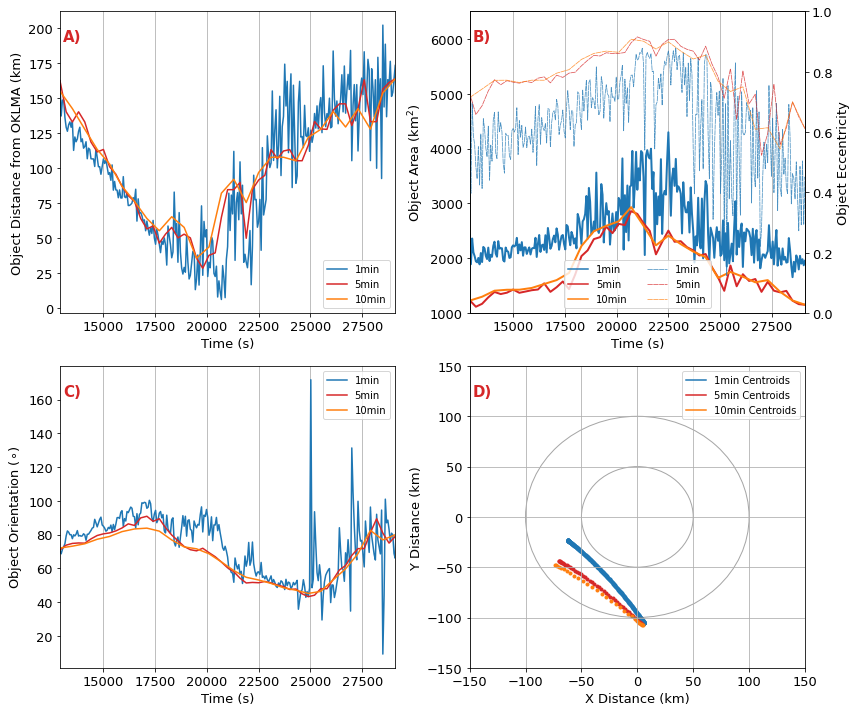

In [6]:
#Set up tuples of data to be passed through plotting function
times = (t1,t5,t10)
dists = (r1,r5,r10)
areas = (a1,a5,a10)
eccs  = (e1,e5,e10)
angles= (ag1,ag5,ag10)
centroids=(c1,c5,c10)
ev.geo_compare(case,dts,times,dists,areas,eccs,angles,centroids,False)

## Plot 1min tracked FOB data:
Purpose of this figure is to illustrate the sensitivity of using the LTR for 1 min resolution FED data. Panels A and B, corresponding to OK-0621 and OK-1021, respectively, show a parameter space defined by the gradient of the FOB orientation in time (x-axis) vs its area. These data are compared to show that where the largest orientation shifts occur for this time resolution corresponds to times when flash rates were low as proxied by small FOB areas. This implies that only large stratiform flashes prevailed. The only other instance where the FOB orientation is expected to shift is when crossing through different quadrants of the analysis domain as exemplified for OK-0621.

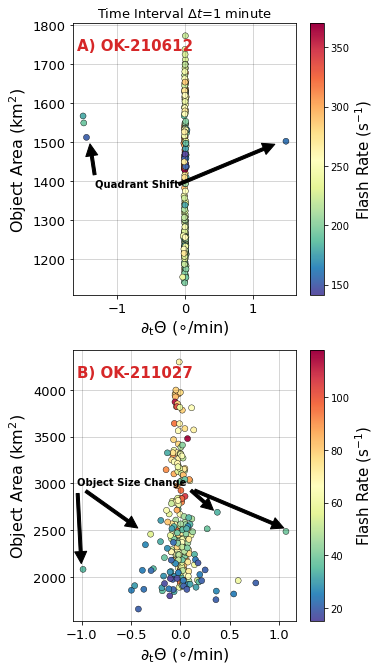

In [7]:
c1b  = pd.read_csv(f'Output/1min/TrackedData/210612/TRACKED-OBJECT-PROPS.csv')
ev.orientation_errors(c1,c1b,in_time1,in_time2,False)

## Track Evaluation Metrics:
The following cells computes the LTR statistics for the OKLMA cases + PERiLS cases to add to the number of samples used to 
evaluate the LTR.

The first cell blocks are boring, and handle the majority of calculations for each case and are annotated respectively.

In [51]:
import importlib
importlib.reload(ev)

<module 'Evaluate' from '/Users/admin/Desktop/Writing/QLCS-Tracking/LTR-LightningTracking/Evaluate.py'>

#### 1) Get FOB and Ellipse data for all cases

In [54]:
#Get FOB and Ellipse data for all cases
cases = ['210612','211027','220322','220330','220405','220413','230226']#,'230216','230303','230324','230331','230405']
case1,ellipse1 = ev.all_cases(cases[0])
case2,ellipse2 = ev.all_cases(cases[1])
case3,ellipse3 = ev.all_cases(cases[2])
case4,ellipse4 = ev.all_cases(cases[3])
case5,ellipse5 = ev.all_cases(cases[4])
case6,ellipse6 = ev.all_cases(cases[5])
case7,ellipse7 = ev.all_cases(cases[6])
#Added:
case8,ellipse8 = ev.all_cases(cases[7])
case9,ellipse9 = ev.all_cases(cases[8])
case10,ellipse10=ev.all_cases(cases[9])
case11,ellipse11=ev.all_cases(cases[10])
case12,ellipse12=ev.all_cases(cases[11])

#### 2) Get Smoothed FOB centroids and the Track Durations
Note some subsetting of data is required for PERiLS cases since the LTR did not work correctly due to limited lightning observations.

In [55]:
#Define the smoothed track centroids + their durations for all cases
cx1,cy1,dur1 = ev.case_durations_centroids(case1,ellipse1,None,None)
cx2,cy2,dur2 = ev.case_durations_centroids(case2,ellipse2,None,None)
cx3,cy3,dur3 = ev.case_durations_centroids(case3,ellipse3,None, 73 )
cx4,cy4,dur4 = ev.case_durations_centroids(case4,ellipse4,10  , 48 )
cx5,cy5,dur5 = ev.case_durations_centroids(case5,ellipse5,88  ,None)
cx6,cy6,dur6 = ev.case_durations_centroids(case6,ellipse6,37  ,None)
cx7,cy7,dur7 = ev.case_durations_centroids(case7,ellipse7,78  ,None)
#Added:
cx8,cy8,dur8 = ev.case_durations_centroids(case8,ellipse8,73  ,143)
cx9,cy9,dur9 = ev.case_durations_centroids(case9,ellipse9,57  ,104)
cx10,cy10,dur10=ev.case_durations_centroids(case10,ellipse10,43  ,94)
cx11,cy11,dur11=ev.case_durations_centroids(case11,ellipse11,144 ,203)
cx12,cy12,dur12=ev.case_durations_centroids(case12,ellipse12,37 ,None)

all_dur = np.hstack([dur1,dur2,dur3,dur4,dur5,dur6,dur7])#,dur8,dur9,dur10,dur11,dur12])

#### 3) Define the linear regression analysis used to compute track linearity and their RMSE (root mean square errors)

In [56]:
#Define linear fit predictions to y-coordinate of tracked centroids for computing the RMSE between them
x1,reg1 = ev.reg_eq(cx1*1e3,cy1*1e3)
x2,reg2 = ev.reg_eq(cx2*1e3,cy2*1e3)
x3,reg3 = ev.reg_eq(cx3*1e3,cy3*1e3)
x4,reg4 = ev.reg_eq(cx4*1e3,cy4*1e3)
x5,reg5 = ev.reg_eq(cx5*1e3,cy5*1e3)
x6,reg6 = ev.reg_eq(cx6*1e3,cy6*1e3)
x7,reg7 = ev.reg_eq(cx7*1e3,cy7*1e3)
#added
x8,reg8 = ev.reg_eq(cx8*1e3,cy8*1e3)
x9,reg9 = ev.reg_eq(cx9*1e3,cy9*1e3)
x10,reg10 = ev.reg_eq(cx10*1e3,cy10*1e3)
x11,reg11 = ev.reg_eq(cx11*1e3,cy11*1e3)
x12,reg12 = ev.reg_eq(cx12*1e3,cy12*1e3)

In [57]:
#Define all track RMSE relative to linear fit
rmse1 = ev.rmse(cx1,cy1,cx1,reg1)
rmse2 = ev.rmse(cx2,cy2,cx2,reg2)
rmse3 = ev.rmse(cx3,cy3,cx3,reg3)
rmse4 = ev.rmse(cx4,cy4,cx4,reg4)
rmse5 = ev.rmse(cx5,cy5,cx5,reg5)
rmse6 = ev.rmse(cx6,cy6,cx6,reg6)
rmse7 = ev.rmse(cx7,cy7,cx7,reg7)
#Added:
rmse8 = ev.rmse(cx8,cy8,cx8,reg8)
rmse9 = ev.rmse(cx9,cy9,cx9,reg9)
rmse10 = ev.rmse(cx10,cy10,cx10,reg10)
rmse11 = ev.rmse(cx11,cy11,cx11,reg11)
rmse12 = ev.rmse(cx12,cy12,cx12,reg12)

all_rmse = np.hstack([rmse1,rmse2,rmse3,rmse4,rmse5,rmse6,rmse7])#,rmse8,rmse9,rmse10,rmse11,rmse12])

#### 4) Define Polynomial Fits for the Track to compute Non-linearity
This is mostly used to demonstrate how linear storm tracks are

In [58]:
#Compute RMSE between non-linear and smoothed tracks:
#get non-linear path prediction:
f1 = np.poly1d(np.polyfit(cx1,cy1,3))
f2 = np.poly1d(np.polyfit(cx2,cy2,3))
f3 = np.poly1d(np.polyfit(cx3,cy3,3))
f4 = np.poly1d(np.polyfit(cx4,cy4,3))
f5 = np.poly1d(np.polyfit(cx5,cy5,3))
f6 = np.poly1d(np.polyfit(cx6,cy6,3))
f7 = np.poly1d(np.polyfit(cx7,cy7,3))
#added:
f8 = np.poly1d(np.polyfit(cx8,cy8,3))
f9 = np.poly1d(np.polyfit(cx9,cy9,3))
f10= np.poly1d(np.polyfit(cx10,cy10,3))
f11= np.poly1d(np.polyfit(cx11,cy11,3))
f12= np.poly1d(np.polyfit(cx12,cy12,3))

#Compute RMSE
rmse1_tri = ev.rmse(cx1,cy1,cx1,f1(cx1))
rmse2_tri = ev.rmse(cx2,cy2,cx2,f2(cx2))
rmse3_tri = ev.rmse(cx3,cy3,cx3,f3(cx3))
rmse4_tri = ev.rmse(cx4,cy4,cx4,f4(cx4))
rmse5_tri = ev.rmse(cx5,cy5,cx5,f5(cx5))
rmse6_tri = ev.rmse(cx6,cy6,cx6,f6(cx6))
rmse7_tri = ev.rmse(cx7,cy7,cx7,f7(cx7))
#Added:
rmse8_tri = ev.rmse(cx8,cy8,cx8,f8(cx8))
rmse9_tri = ev.rmse(cx9,cy9,cx9,f9(cx9))
rmse10_tri= ev.rmse(cx10,cy10,cx10,f10(cx10))
rmse11_tri= ev.rmse(cx11,cy11,cx11,f11(cx11))
rmse12_tri= ev.rmse(cx12,cy12,cx12,f12(cx12))

#Set hstack array and define the polynomial (3rd order) fits
all_rmse_tri = np.hstack([rmse1_tri,rmse2_tri,rmse3_tri,rmse4_tri,rmse5_tri,rmse6_tri,rmse7_tri])#,rmse8_tri,rmse9_tri,rmse10_tri,rmse11_tri,rmse12_tri])
eqs = ['{0:.2e}'.format(f[0])+r'$x^3$'+'{0:.2e}'.format(f[1])+r'$x^2$'+'{0:.2e}'.format(f[2])+'x'+'{0:.2e}'.format(f[3]) for f in [f1,f2,f3,f4,f5,f6,f7]]

#### 5) Compute LTR Track Consistency (standard deviation of areas) and Centroid Deviation (differences)
Used to exhibit the consistency of the LTR across time as storm evoles and decays.

In [59]:
#centroid difference & feature consistency (area):
std1 = np.std(case1.area)
std2 = np.std(case2.area)
std3 = np.std(case3.area)
std4 = np.std(case4.area)
std5 = np.std(case5.area)
std6 = np.std(case6.area)
std7 = np.std(case7.area)
#added:
std8 = np.std(case8.area)
std9 = np.std(case9.area)
std10= np.std(case10.area)
std11= np.std(case11.area)
std12= np.std(case12.area)
all_std = np.hstack([std1,std2,std3,std4,std5,std6,std7,std8,std9,std10,std11,std12])

#Centroid diffs
diff1 = np.nanmean(np.abs((np.sqrt(cx1**2 + cy1**2)[1:] - np.sqrt(cx1**2 + cy1**2)[:-1]))) * 1e0
diff2 = np.nanmean(np.abs((np.sqrt(cx2**2 + cy2**2)[1:] - np.sqrt(cx2**2 + cy2**2)[:-1]))) * 1e0
diff3 = np.nanmean(np.abs((np.sqrt(cx3**2 + cy3**2)[1:] - np.sqrt(cx3**2 + cy3**2)[:-1]))) * 1e0
diff4 = np.nanmean(np.abs((np.sqrt(cx4**2 + cy4**2)[1:] - np.sqrt(cx4**2 + cy4**2)[:-1]))) * 1e0
diff5 = np.nanmean(np.abs((np.sqrt(cx5**2 + cy5**2)[1:] - np.sqrt(cx5**2 + cy5**2)[:-1]))) * 1e0
diff6 = np.nanmean(np.abs((np.sqrt(cx6**2 + cy6**2)[1:] - np.sqrt(cx6**2 + cy6**2)[:-1]))) * 1e0
diff7 = np.nanmean(np.abs((np.sqrt(cx7**2 + cy7**2)[1:] - np.sqrt(cx7**2 + cy7**2)[:-1]))) * 1e0
#Added:
diff8 = np.nanmean(np.abs((np.sqrt(cx8**2 + cy8**2)[1:] - np.sqrt(cx8**2 + cy8**2)[:-1]))) * 1e0
diff9 = np.nanmean(np.abs((np.sqrt(cx9**2 + cy9**2)[1:] - np.sqrt(cx9**2 + cy9**2)[:-1]))) * 1e0
diff10= np.nanmean(np.abs((np.sqrt(cx10**2 + cy10**2)[1:] - np.sqrt(cx10**2 + cy10**2)[:-1]))) * 1e0
diff11= np.nanmean(np.abs((np.sqrt(cx11**2 + cy11**2)[1:] - np.sqrt(cx11**2 + cy11**2)[:-1]))) * 1e0
diff12= np.nanmean(np.abs((np.sqrt(cx12**2 + cy12**2)[1:] - np.sqrt(cx12**2 + cy12**2)[:-1]))) * 1e0

all_diffs = np.hstack([diff1,diff2,diff3,diff4,diff5,diff6,diff7])#,diff8,diff9,diff10,diff11,diff12])

## Generate Plots to Illustrate Smoothed and Linear LTR tracks
<b>Note: Not used in paper</b>

In [60]:
all_x  = [x1,x2,x3,x4,x5,x6,x7]              #,x8,x9,x10,x11,x12]
all_y  = [cy1,cy2,cy3,cy4,cy5,cy6,cy7]       #,cy8,cy9,cy10,cy11,cy12]
all_reg= [reg1,reg2,reg3,reg4,reg5,reg6,reg7]#,reg8,reg9,reg10,reg11,reg12]

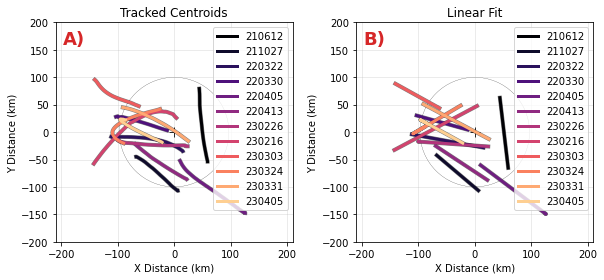

In [61]:
ev.centroid_plots(cases,all_x,all_y,all_reg,False)

## Generate Plots With LTR Evaluation Metrics/Statistics

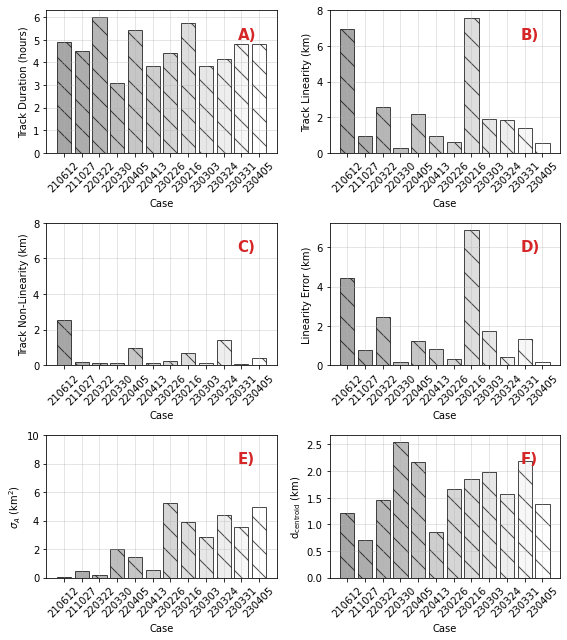

In [62]:
ev.ltr_eval(cases,all_dur,all_rmse,all_rmse_tri,all_std,all_diffs,False)

Ellipse and FED Coverage:
-----

Plot the areal coverage of the tracked ellipses used to generate the sampling grids relative to the FED footprint through each case's analysis duration. 

<font color='red'><b>WARNING:</b></font> <b><i>Running this cell without all cases will result in an error. Do not run if data are not available! This figure is NOT used in the paper.</i></b>

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
#Grid Path Postagestamps
xrange = np.arange(-300,300,1)
yrange = np.arange(-300,300,1)
xm,ym  = np.meshgrid(xrange,yrange)

In [65]:
img1,fed1,xg1,yg1 = ev.get_traces('20210612',ellipse1,xm,ym,None,None)
img2,fed2,xg2,yg2 = ev.get_traces('20211027',ellipse2,xm,ym,None,None)
img3,fed3,xg3,yg3 = ev.get_traces('20220322',ellipse3,xm,ym,None,73  )
img4,fed4,xg4,yg4 = ev.get_traces('20220330',ellipse4,xm,ym,10  , 48 )
img5,fed5,xg5,yg5 = ev.get_traces('20220405',ellipse5,xm,ym,88  ,None)
img6,fed6,xg6,yg6 = ev.get_traces('20220413',ellipse6,xm,ym,37  ,None)
img7,fed7,xg7,yg7 = ev.get_traces('20230226',ellipse7,xm,ym,78  ,None)
img8,fed8,xg8,yg8 = ev.get_traces('20230216',ellipse8,xm,ym,73  ,143 )
img9,fed9,xg9,yg9 = ev.get_traces('20230303',ellipse9,xm,ym,57  ,104 )
img10,fed10,xg10,yg10 = ev.get_traces('20230324',ellipse10,xm,ym,43,94)
img11,fed11,xg11,yg11 = ev.get_traces('20230331',ellipse11,xm,ym,144,203)
img12,fed12,xg12,yg12 = ev.get_traces('20230405',ellipse12,xm,ym,37,None)

In [66]:
images = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10,img11,img12]
feds   = [fed1,fed2,fed3,fed4,fed5,fed6,fed7,fed8,fed9,fed10,fed11,fed12]
xgs    = [xg1,xg2,xg3,xg4,xg5,xg6,xg7,xg8,xg9,xg10,xg11,xg12]
ygs    = [yg1,yg2,yg3,yg4,yg5,yg6,yg7,yg8,yg9,yg10,yg11,yg12]

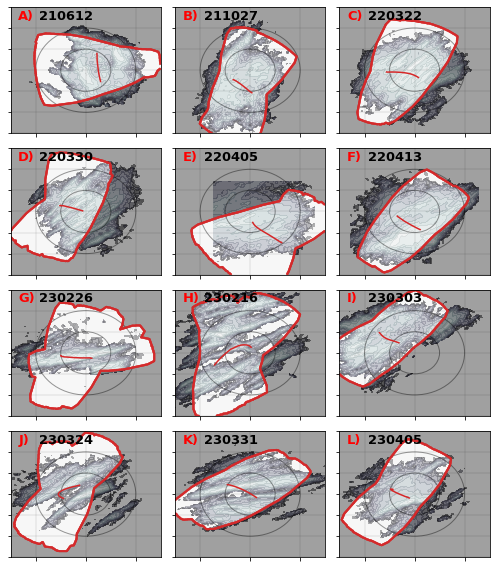

In [67]:
fig,ax = plt.subplots(4,3,figsize=(7,8))


for i,(axs,xg,yg,fed,img,cx,cy) in enumerate(zip(ax.flatten(),xgs,ygs,feds,images,all_x,all_y)):

    axs.contourf(xg*1e-3,yg*1e-3,np.log10(np.nancumsum(fed,axis=0)[-1]),10,cmap='bone',alpha=0.5)
    axs.contour (xg*1e-3,yg*1e-3,np.log10(np.nancumsum(fed,axis=0)[-1]),10,colors='k',linewidths=0.1,alpha=0.5)

    axs.contourf (xm,ym,np.max(img,axis=0),cmap='gray',alpha=0.4,linewidths=2)
    axs.contour  (xm,ym,np.max(img,axis=0),colors='C3',alpha=0.4,linewidths=2)

    axs.plot(cx,cy,color='C3')
    
    
    circle1 = plt.Circle((0, 0), 100, fill=False,edgecolor='k',linewidth=1,alpha=0.4,linestyle='-')
    circle2 = plt.Circle((0, 0), 200, fill=False,edgecolor='k',linewidth=1,alpha=0.4,linestyle='-')
    axs.add_patch(circle1)
    axs.add_patch(circle2)
    
labels = ['A)','B)','C)',
          'D)','E)','F)',
          'G)','H)','I)',
          'J)','K)','L)']

[axs.set_xlim(-300,300) for axs in ax.flatten()]
[axs.set_ylim(-300,300) for axs in ax.flatten()]
[axs.text(.05,.9,l,color='red',weight='bold',transform=axs.transAxes,fontsize=13) for (axs,l) in zip(ax.flatten(),labels)]
[axs.text(.19,.9,c,color='k',weight='bold',transform=axs.transAxes,fontsize=13) for (axs,c) in zip(ax.flatten(),cases)]

[axs.grid(color='k',linewidth=0.1) for axs in ax.flatten()]
[axs.set_xticklabels([]) for axs in ax.flatten()]
[axs.set_yticklabels([]) for axs in ax.flatten()]
plt.tight_layout()
plt.savefig('PaperFigures/ALL_CASE_OUTLINES.pdf',dpi=200,bbox_inches='tight')

Geometric Time Series Combine:
-----
Produce combined figure for both OK-0621 and OK-1021 figures containing the time series of the FOB geometric properties.

In [221]:
img1 = plt.imread('PaperFigures/NotUsed/TRACK_COMPARE-OK210612.png')
img2 = plt.imread('PaperFigures/NotUsed/TRACK_COMPARE-OK211027.png')

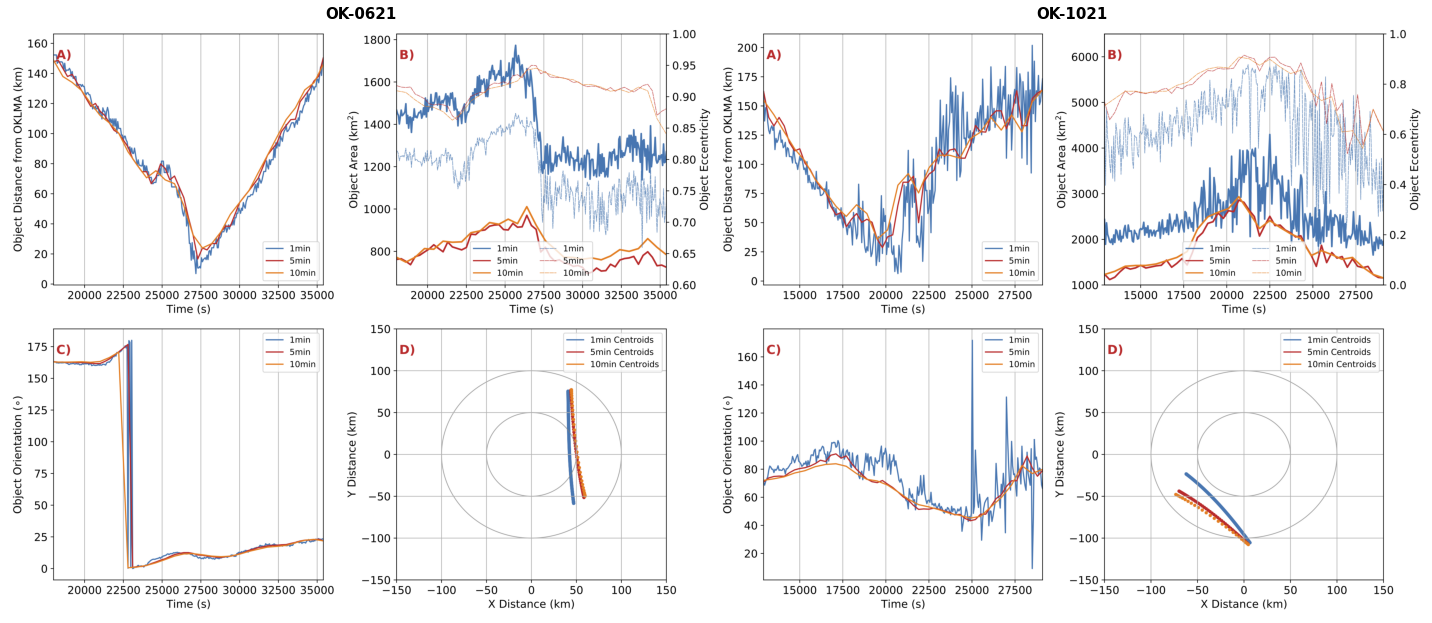

In [255]:
fig,ax = plt.subplots(1,2,figsize=(20,16))
ax[0].imshow(img1)
ax[1].imshow(img2)
[axs.set_xticks([]) for axs in ax.flatten()]
[axs.set_yticks([]) for axs in ax.flatten()]
[axs.spines['top'].set_visible(False) for axs in ax.flatten()]
[axs.spines['right'].set_visible(False) for axs in ax.flatten()]
[axs.spines['bottom'].set_visible(False) for axs in ax.flatten()]
[axs.spines['left'].set_visible(False) for axs in ax.flatten()]

ax[0].set_title(f'OK-0621',fontsize=15,weight='bold')
ax[1].set_title(f'OK-1021',fontsize=15,weight='bold')
plt.tight_layout(h_pad=0,w_pad=0.2)
plt.savefig('/Users/admin/Desktop/GEO_COMBINED.pdf',dpi=200,bbox_inches='tight')